# Risk Analyzer: Identifying Companies Exposed to U.S. Import Tariffs against China


## Why It Matters
Understanding how companies are exposed to highly uncertain scenarios and risk channels, like geopolitical and economic risks, is critical for informed decision-making. As shifting policies, sanctions, and trade barriers redefine market dynamics, organizations must proactively assess their vulnerability to emerging threats.


## What It Does
The `RiskAnalyzer` class, part of the bigdata-research-tools package, is purpose-built to meet this challenge. Designed for risk analysts, portfolio managers, and investment professionals, it systematically analyzes corporate exposure to specific risk channels using unstructured data from news, earnings calls, and regulatory filings.

## How It Works
RiskAnalyzer combines **hybrid semantic search**, **risk factor taxonomies**, and **structured validation techniques** to deliver:

- **Targeted extraction of risk signals** and supporting evidence from massive unstructured datasets
- **Standardized exposure metrics** to compare risk across firms, sectors, or portfolios
- **Actionable insights** that inform investment strategies and enterprise risk decisions
- **Time-based monitoring** to track how exposure levels shift in response to world events

## A Real-World Use Case
This cookbook illustrates the full workflow through a practical example: identifying companies impacted by new U.S. import tariffs on China. You'll learn how to convert unstructured narrative (news articles) into structured, quantifiable risk intelligence.


## Setup and Imports

## Async Compatibility Setup

**Run this cell first** - Required for Google Colab, Jupyter Notebooks, and VS Code with Jupyter extension:

### Why is this needed?

Interactive environments (Colab, Jupyter) already have an asyncio event loop running. When bigdata-research-tools makes async API calls (like to OpenAI), you'll get this error without nest_asyncio:

```
RuntimeError: asyncio.run() cannot be called from a running event loop
```

The `nest_asyncio.apply()` command patches this to allow nested event loops.

💡 **Tip**: If you're unsure which environment you're in, just run the cell below - it won't hurt in any environment!

In [2]:
import datetime
start = datetime.datetime.now()

try:
    import asyncio
    asyncio.get_running_loop()
    import nest_asyncio; nest_asyncio.apply()
    print("✅ nest_asyncio applied")
except (RuntimeError, ImportError):
    print("✅ nest_asyncio not needed or not available")

✅ nest_asyncio applied


## Environment Setup

The following cell configures the necessary path for the analysis

In [3]:
import os
import sys


current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)
print(f"✅ Local environment setup complete")

✅ Local environment setup complete


## Import Required Libraries

Import the core libraries needed for regulatory issues analysis, including the custom report generation classes and data processing tools.

In [ ]:
import sys
import os
import pandas as pd

from src.tool import display_figures

from bigdata_client import Bigdata
from bigdata_client.models.entities import Company
from bigdata_client.models.search import DocumentType

# Bigdata Research Tools imports
from bigdata_research_tools.workflows.risk_analyzer import RiskAnalyzer

## Optional: Plotly Display Configuration

For better visualization rendering, you can also set the Plotly renderer:

In [53]:
import plotly.io as pio

# Try to detect the environment and set appropriate renderer
try:
    # Check if we're in JupyterLab
    import os
    if 'JUPYTERHUB_SERVICE_PREFIX' in os.environ or 'JPY_SESSION_NAME' in os.environ:
        pio.renderers.default = 'jupyterlab'
        print("✅ Plotly configured for JupyterLab")
    else:
        # Default for VS Code, Jupyter Notebook, etc.
        pio.renderers.default = 'plotly_mimetype+notebook'
        print("✅ Plotly configured for Jupyter/VS Code")
except:
    # Fallback to a more universal renderer
    pio.renderers.default = 'notebook'
    print("✅ Plotly configured with fallback renderer")

✅ Plotly configured for Jupyter/VS Code


## Define Output Paths

We define the output paths for our thematic screening results.

In [6]:
# Define output file paths for our report
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

export_path = f"{output_dir}/risk_analyzer_results.xlsx"

## Load Credentials

In [7]:

from dotenv import load_dotenv
from pathlib import Path

script_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
load_dotenv(script_dir / '.env')

BIGDATA_USERNAME = os.getenv('BIGDATA_USERNAME')
BIGDATA_PASSWORD = os.getenv('BIGDATA_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

if not all([BIGDATA_USERNAME, BIGDATA_PASSWORD, OPENAI_API_KEY]):
    print("❌ Missing required environment variables")
    raise ValueError("Missing required environment variables. Check your .env file.")
else:
    print("✅ Credentials loaded from .env file")

✅ Credentials loaded from .env file


## Connecting to Bigdata

Create a Bigdata object with your credentials.

In [8]:
bigdata = Bigdata(BIGDATA_USERNAME, BIGDATA_PASSWORD)

## Defining Your Risk Analysis Parameters





To perform a portfolio risk analysis, we need to define several key parameters:

- **Main Theme** (`main_theme`): The risk scenario to analyze (e.g. US Import Tariffs against China)

- **Focus** (`focus`): The analyst focus that provides an expert perspective on the scenario and helps break it down into risks

- **Company Universe** (`companies`): The set of companies to screen

- **Control Entities** (`control_entities`): The countries, people, or organizations that characterize the risk scenario

- **Keywords** (`keywords`): The key concepts of the risk scenario

- **Time Period** (`start_date` and `end_date`): The date range over which to run the search

- **Document Type** (`document_type`): Specify which documents to search over (transcripts, filings, news)

- **Fiscal Year** (`fiscal_year`): If the document type is transcripts or filings, fiscal year needs to be specified

- **Sources** (`sources`): Specify set of sources within a document type, for example which news outlets (available via Bigdata API) you wish to search over

- **Model Selection** (`llm_model`): The AI model used for semantic analysis

- **Rerank Threshold** (`rerank_threshold`): By setting this value, you’re enabling the cross-encoder which reranks the results and selects those whose relevance is above the percentile you specify (0.7 being the 70th percentile). More information on the re-ranker can be found [here](https://docs.bigdata.com/how-to-guides/rerank_search).

- **Export Path** (`export_path`): The path to export the results in an Excel file

In [9]:
# ===== Risk Definition =====
main_theme = 'New US import tariffs against China would impact American companies'
focus = "Provide a detailed taxonomy of risks describing how new American import tariffs against China will impact US companies, their operations and strategy. Cover trade-relations risks, foreign market access risks, supply chain risks, US market sales and revenue risks (including price impacts), and intellectual property risks, provide at least 4 sub-scenarios for each risk factor."

# ===== Company Universe (from Watchlist) =====
# Get Top US 100 watchlist from Bigdata.com
top100_watchlist_id = "44118802-9104-4265-b97a-2e6d88d74893"
watchlist = bigdata.watchlists.get(top100_watchlist_id)
companies = bigdata.knowledge_graph.get_entities(watchlist.items)

# ===== LLM Specification =====
llm_model = "openai::gpt-4o-mini"

# ===== Query Configuration =====
document_type = DocumentType.NEWS

# ===== Enable/Disable Reranker =====
rerank_threshold = None

# ===== Specify Time Range =====
start_date = "2025-04-01"
end_date = "2025-06-30"


# ===== Risk Scenario Parameters =====
countries_at_risk = {'place':['China']}
keywords = ['Tariffs']

##  Instantiating and Running the Risk Analyzer

The ``RiskAnalyzer`` class handles the complete risk analysis workflow:
- **Taxonomy Creation**: Automatically generates a hierarchical tree for US Import Tariffs
- **Content Retrieval**: Searches news for relevant discussions
- **Semantic Labeling**: Uses AI to categorize content into appropriate sub-scenarios
- **Scoring**: Calculates company and industry-level exposure scores

In [10]:
# Create the thematic screener instance
analyzer = RiskAnalyzer(
    llm_model=llm_model,
    main_theme=main_theme,
    companies=companies,
    start_date=start_date,
    end_date=end_date,
    keywords=keywords,
    document_type=document_type,
    control_entities=countries_at_risk,
    sources=None,  # Optional filtering by sources
    rerank_threshold=rerank_threshold,  # Optional reranking threshold
    focus=focus  # Optional focus to narrow the theme
)

## Mindmap a Risk Taxonomy with Bigdata Research Tools

You can leverage Bigdata Research Tools to generate a comprehensive risk taxonomy with an LLM, breaking down a complex risk scenario into well-defined risks and sub-scenarios for more targeted analysis.

In [30]:
risk_tree, risk_summaries, terminal_labels = analyzer.create_taxonomy()

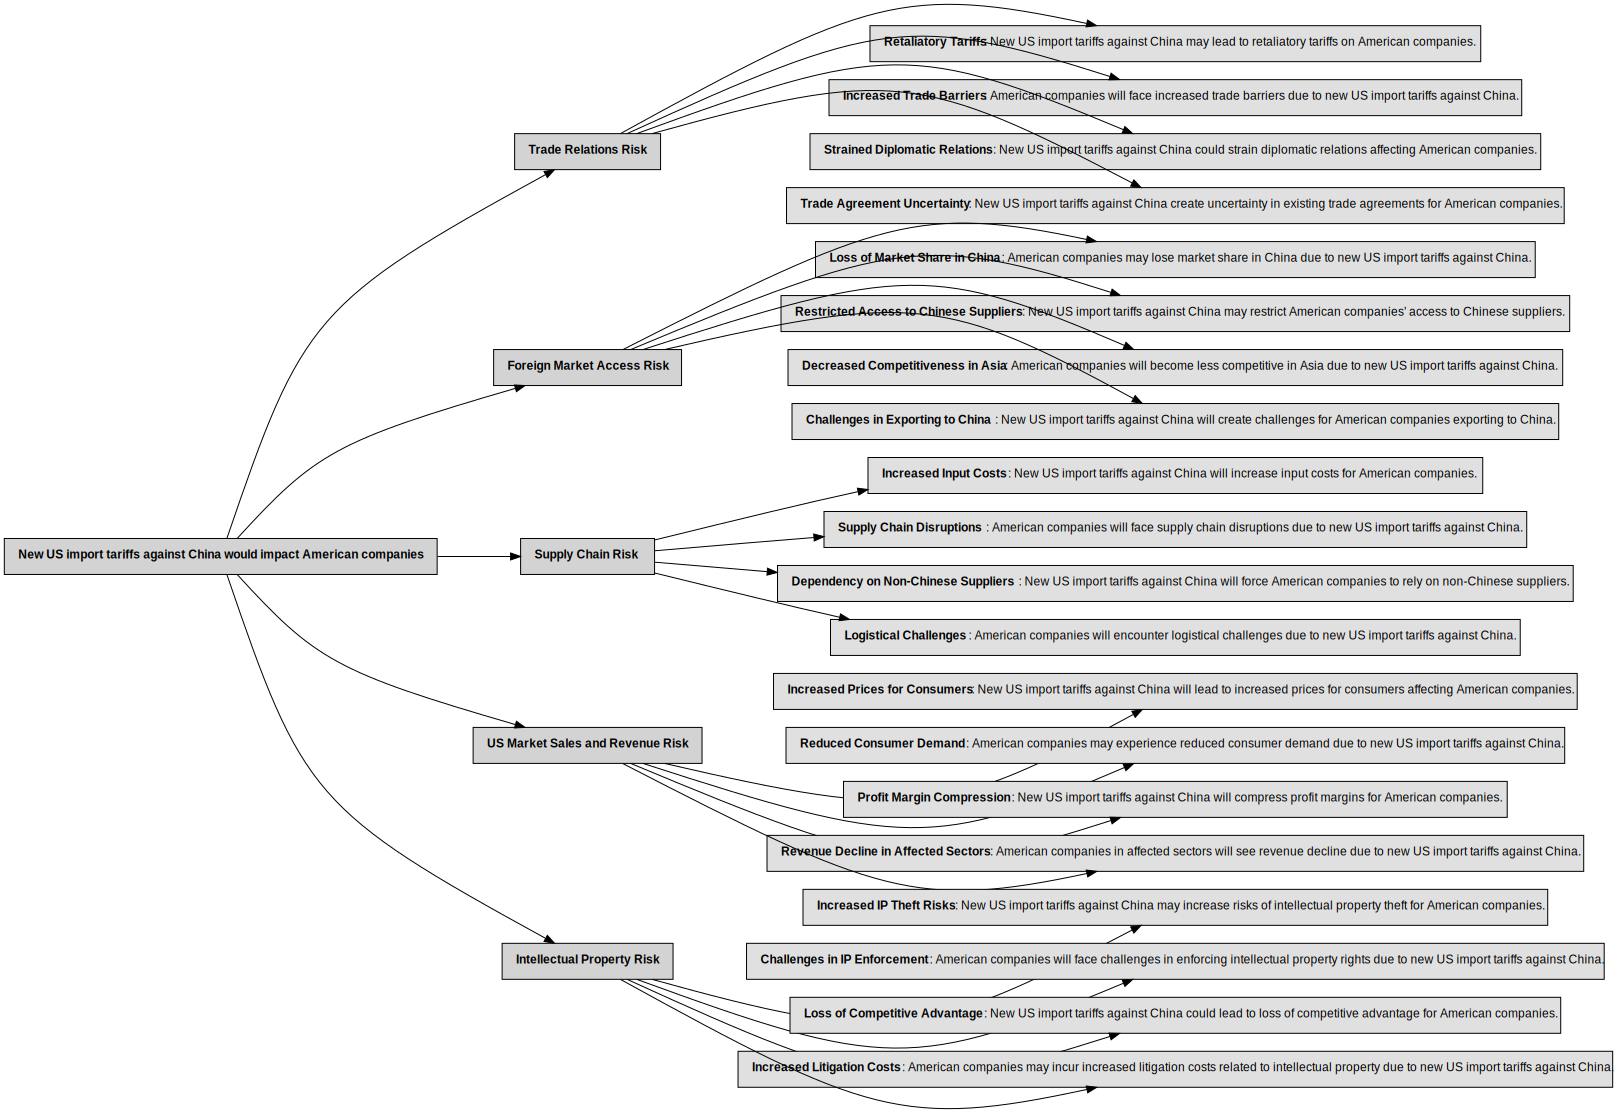

In [31]:
risk_tree.visualize()

The taxonomy tree includes descriptive sentences that explicitly connect each sub-scenario back to the “US Import Tariffs" risk scenario, ensuring all search results remain contextually relevant to our main risk.

In [33]:
risk_summaries

['New US import tariffs against China may lead to retaliatory tariffs on American companies.',
 'American companies will face increased trade barriers due to new US import tariffs against China.',
 'New US import tariffs against China could strain diplomatic relations affecting American companies.',
 'New US import tariffs against China create uncertainty in existing trade agreements for American companies.',
 'American companies may lose market share in China due to new US import tariffs against China.',
 "New US import tariffs against China may restrict American companies' access to Chinese suppliers.",
 'American companies will become less competitive in Asia due to new US import tariffs against China.',
 'New US import tariffs against China will create challenges for American companies exporting to China.',
 'New US import tariffs against China will increase input costs for American companies.',
 'American companies will face supply chain disruptions due to new US import tariffs ag

## Retrieve Content

With the risk taxonomy and screening parameters, you can leverage the  Search functionalities in bigdata-research-tools, built with Bigdata API, to run search at scale on your portfolio against news documents. We need to define 3 more parameters for searching:

- **Frequency** (`freq`): The frequency of the date ranges to search over. Supported values:
    - `Y`: Yearly intervals.
    - `M`: Monthly intervals.
    - `W`: Weekly intervals.
    - `D`: Daily intervals. Defaults to `3M`.
- **Document Limit** (`document_limit`): The maximum number of documents to return per query to Bigdata API.
- **Batch Size** (`batch_size`): The number of entities to include in a single batched query.

In [34]:
# ===== Query Configuration =====
document_limit = 100  # Maximum number of documents to retrieve per query
batch_size = 10  # Number of companies to process in each query
frequency = 'M'  # Query frequency

In [35]:
df_sentences = analyzer.retrieve_results(
            sentences=risk_summaries,
            freq=frequency,
            document_limit=document_limit,
            batch_size=batch_size,
        )

Processing news results...: 100%|██████████| 57980/57980 [00:08<00:00, 7234.84it/s] 


DataFrame Summary:

In [36]:
df_sentences.head()

,timestamp_utc,document_id,sentence_id,headline,entity_id,document_type,is_reporting_entity,entity_name,entity_sector,entity_industry,entity_country,entity_ticker,text,other_entities,entities,masked_text,other_entities_map
0,2025-04-01 10:57:16+00:00,EF9F04B3039ED64AD6ECC05CA796D724,EF9F04B3039ED64AD6ECC05CA796D724-4,Stock Market Today: Stocks mixed as investors ...,50070E,news,False,Goldman Sachs Group Inc.,Financials,Investment Services,United States,GS,"With new levies on the auto, steel and aluminu...",,"[{'key': '50070E', 'name': 'Goldman Sachs Grou...","With new levies on the auto, steel and aluminu...",None
1,2025-04-01 15:10:06+00:00,228FBD55A57619688B5627883B90BE12,228FBD55A57619688B5627883B90BE12-4,Trump 'Liberation Day' Tariffs Could Drive US ...,E09E2B,news,False,NVIDIA Corp.,Technology,Semiconductors,United States,NVDA,"The brokerage said that the ""broader worry is ...",Huawei Technologies Co. Ltd.,"[{'key': 'E09E2B', 'name': 'NVIDIA Corp.', 'ti...","The brokerage said that the ""broader worry is ...","[(1, Huawei Technologies Co. Ltd.)]"
2,2025-04-01 17:59:58+00:00,0A73E539891B6B78E469FF4E1D38E5AE,0A73E539891B6B78E469FF4E1D38E5AE-3,Tariffs Could Shake Building Industry: Homebui...,990AD0,news,False,Bank of America Corp.,Financials,Diversified Banks,United States,BAC,"In a report on Tuesday, a BofA analyst says Ch...","Masco Corp., Fortune Brands Innovations Inc., ...","[{'key': '3F4497', 'name': 'Masco Corp.', 'tic...","In a report on Tuesday, a Target Companyny ana...","[(2, Whirlpool Corp.), (3, Fortune Brands Inno..."
3,2025-04-01 17:59:58+00:00,0A73E539891B6B78E469FF4E1D38E5AE,0A73E539891B6B78E469FF4E1D38E5AE-5,Tariffs Could Shake Building Industry: Homebui...,990AD0,news,False,Bank of America Corp.,Financials,Diversified Banks,United States,BAC,BofA analyst writes that U.S. tariffs on China...,,"[{'key': '990AD0', 'name': 'Bank of America Co...",Target Companyny analyst writes that U.S. tari...,None
4,2025-04-02 00:20:33+00:00,D7E53E78697CA4C3B35E864DA8E1F767,D7E53E78697CA4C3B35E864DA8E1F767-4,Can Trump's trade war with China correct years...,713810,news,False,Walmart Inc.,Consumer Services,Department Stores,United States,WMT,"His products are sold around the world, with t...",,"[{'key': '713810', 'name': 'Walmart Inc.', 'ti...","His products are sold around the world, with t...",None


## Label the Results

Use an LLM to analyze each text chunk and determine its relevance to the sub-scenario. Any chunks which aren’t explicitly linking the companies mentioned to the risk sub-scenarios will be filtered out.

In [37]:
df, df_labeled = analyzer.label_search_results(
            df_sentences=df_sentences,
            terminal_labels=terminal_labels,
            risk_tree=risk_tree,
            additional_prompt_fields=['entity_sector','entity_industry', 'headline']
        )

Querying OpenAI...:   0%|          | 0/8815 [00:00<?, ?it/s]

Querying OpenAI...: 100%|██████████| 8815/8815 [07:50<00:00, 18.74it/s]


## Assess Risk Exposure

We will look at the most exposed companies to the risks stemming from new US Import Tariffs against China. The function `generate_results` will calculate the composite score, summing up the scores across the sub-scenarios for each company (df_company) or industry (df_industry) and add a global motivation statement (df_motivation).

In [38]:
df_company, df_industry, df_motivation = analyzer.generate_results(df_labeled)

Found 80 unique companies with quotes


Generating motivations for 80 companies: 100%|██████████| 80/80 [04:22<00:00,  3.28s/company]


In [39]:
df_company.head()

,Company,Ticker,Sector,Industry,Challenges in Exporting to China,Decreased Competitiveness in Asia,Decreased Input Costs,Dependency on Non-Chinese Suppliers,Increased Access to Chinese Suppliers,Increased Competition,...,Profit Margin Compression,Reduced Consumer Demand,Restricted Access to Chinese Suppliers,Retaliatory Tariffs,Revenue Decline in Affected Sectors,Strained Diplomatic Relations,Supply Chain Disruption,Supply Chain Disruptions,Trade Agreement Uncertainty,Composite Score
0,Apple Inc.,AAPL,Technology,Computer Hardware,3,1,0,2,0,0,...,15,1,1,22,103,0,7,207,7,1201
1,Walmart Inc.,WMT,Consumer Services,Department Stores,0,0,0,0,0,0,...,11,2,0,5,25,0,0,93,7,550
2,Boeing Co.,BA,Industrials,Aerospace,52,3,0,0,0,0,...,0,0,1,77,75,0,0,51,10,436
3,NVIDIA Corp.,NVDA,Technology,Semiconductors,30,3,0,0,0,0,...,1,0,0,12,91,1,0,31,7,382
4,Amazon.com Inc.,AMZN,Consumer Services,Internet & Direct Marketing Retail,0,0,0,0,0,1,...,2,3,0,0,57,0,0,33,3,321


In [40]:
df_industry.head()

,Industry,Challenges in Exporting to China,Decreased Competitiveness in Asia,Decreased Input Costs,Dependency on Non-Chinese Suppliers,Increased Access to Chinese Suppliers,Increased Competition,Increased Competitiveness in Asia,Increased Consumer Demand,Increased Demand Due to Protectionism,...,Profit Margin Compression,Reduced Consumer Demand,Restricted Access to Chinese Suppliers,Retaliatory Tariffs,Revenue Decline in Affected Sectors,Strained Diplomatic Relations,Supply Chain Disruption,Supply Chain Disruptions,Trade Agreement Uncertainty,Composite Score
0,Computer Hardware,3,1,0,2,0,0,1,0,0,...,15,1,1,22,103,0,7,207,7,1201
1,Semiconductors,34,7,0,0,0,0,5,0,0,...,3,0,0,28,147,1,0,52,16,591
2,Department Stores,0,0,0,0,0,0,0,0,0,...,11,2,0,5,25,0,0,93,7,550
3,Aerospace,52,3,0,0,0,0,1,0,0,...,2,0,1,79,82,0,0,54,10,466
4,Automobiles,14,3,0,0,1,0,2,0,1,...,17,1,3,14,74,0,0,69,10,448


In [41]:
df_motivation.head()

,Company,Motivation,Composite Score
0,Apple Inc.,Apple Inc. is included in the thematic watchli...,1201
1,Walmart Inc.,Walmart Inc. is included in the thematic watch...,550
2,Boeing Co.,Boeing Co. is included in the thematic watchli...,436
3,NVIDIA Corp.,NVIDIA Corp. is included in the thematic watch...,382
4,Amazon.com Inc.,Amazon.com Inc. is included in the thematic wa...,321


Now, let’s visualize the results using Plotly to create an interactive dashboard:

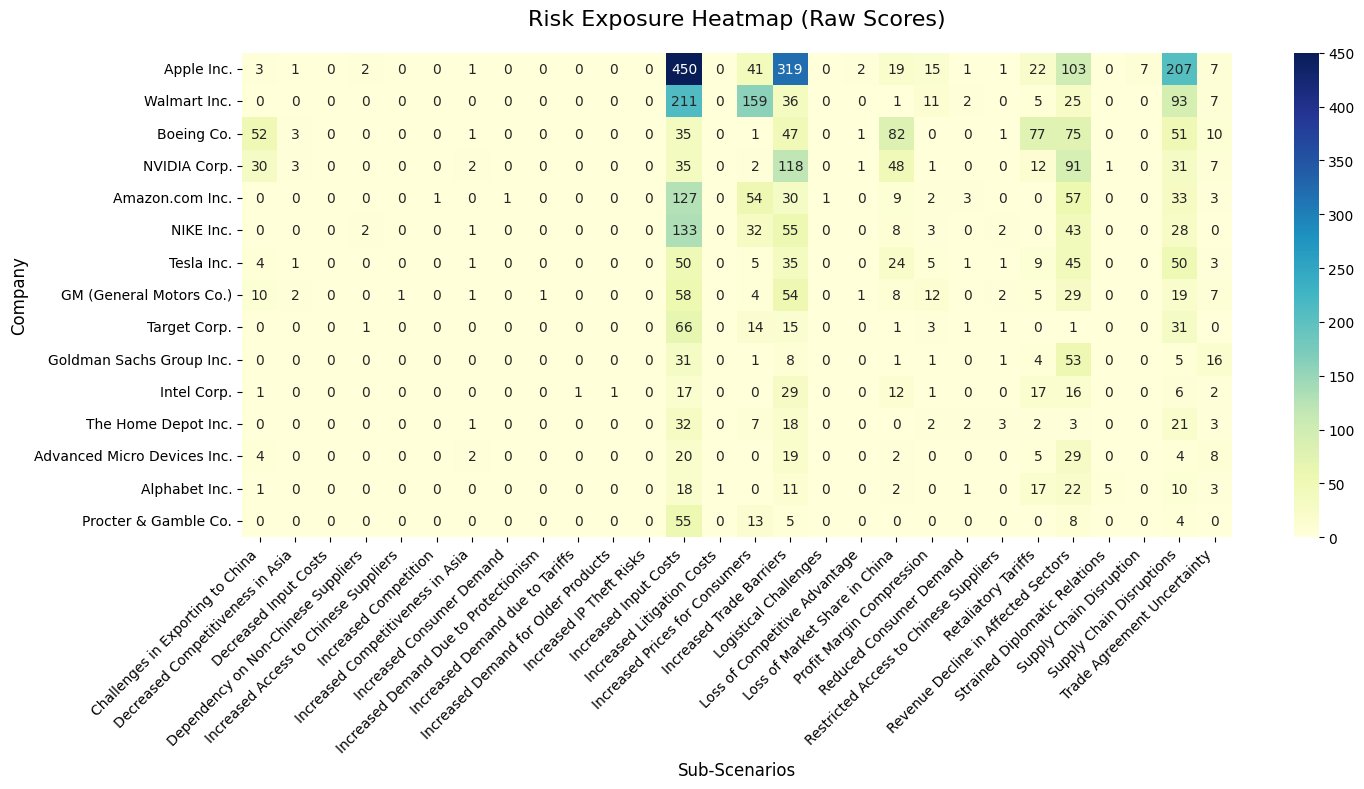

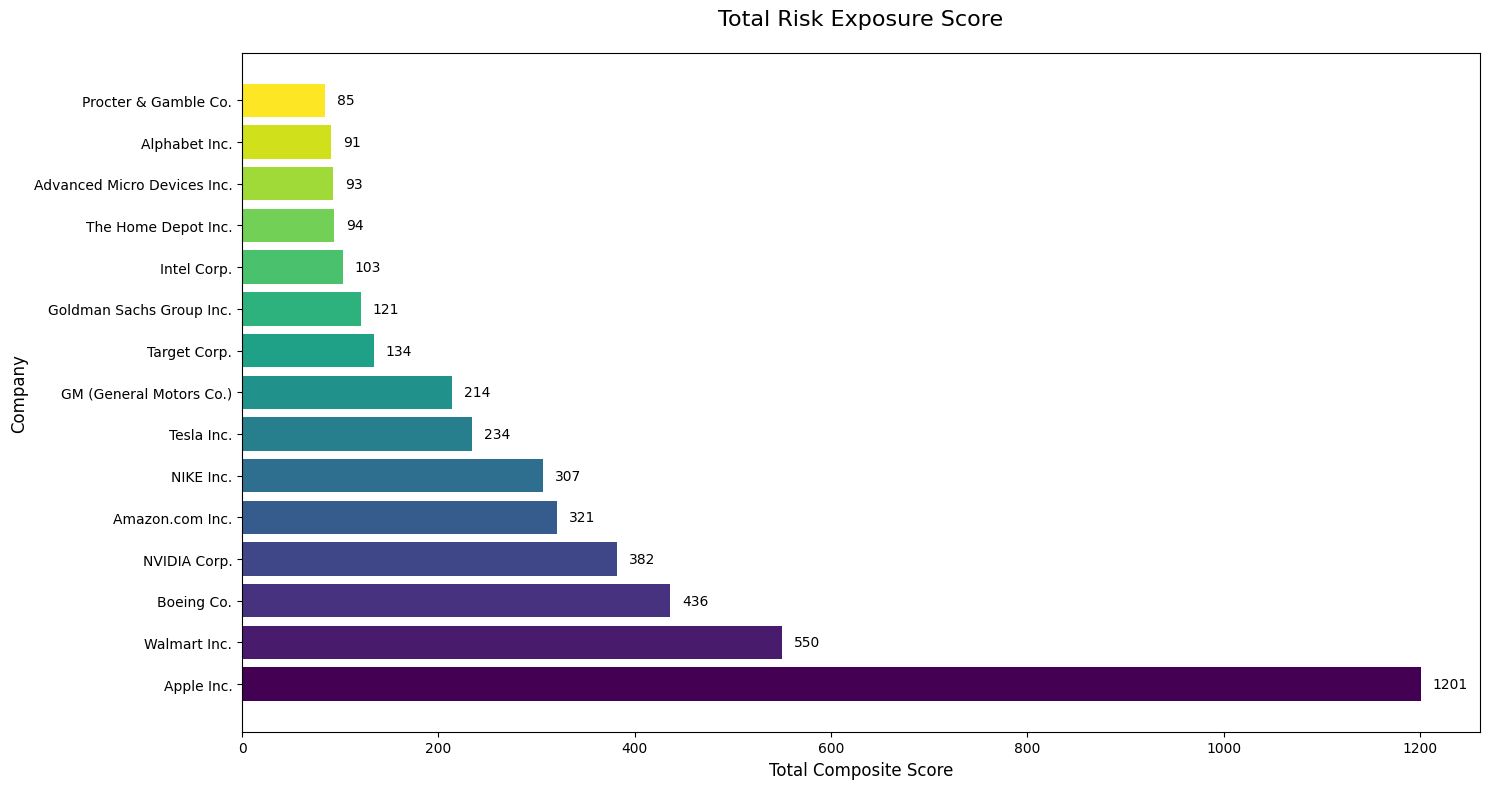

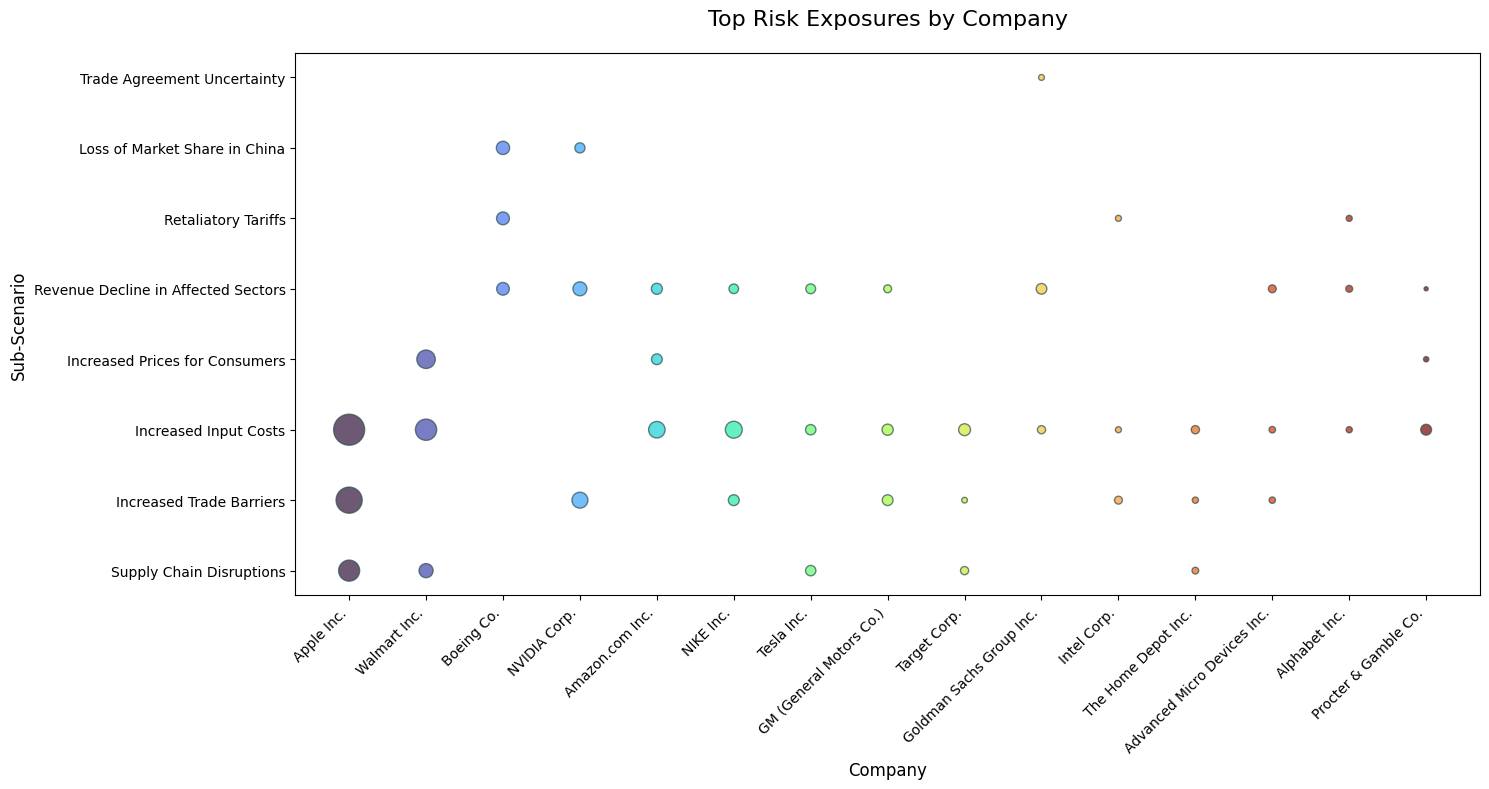

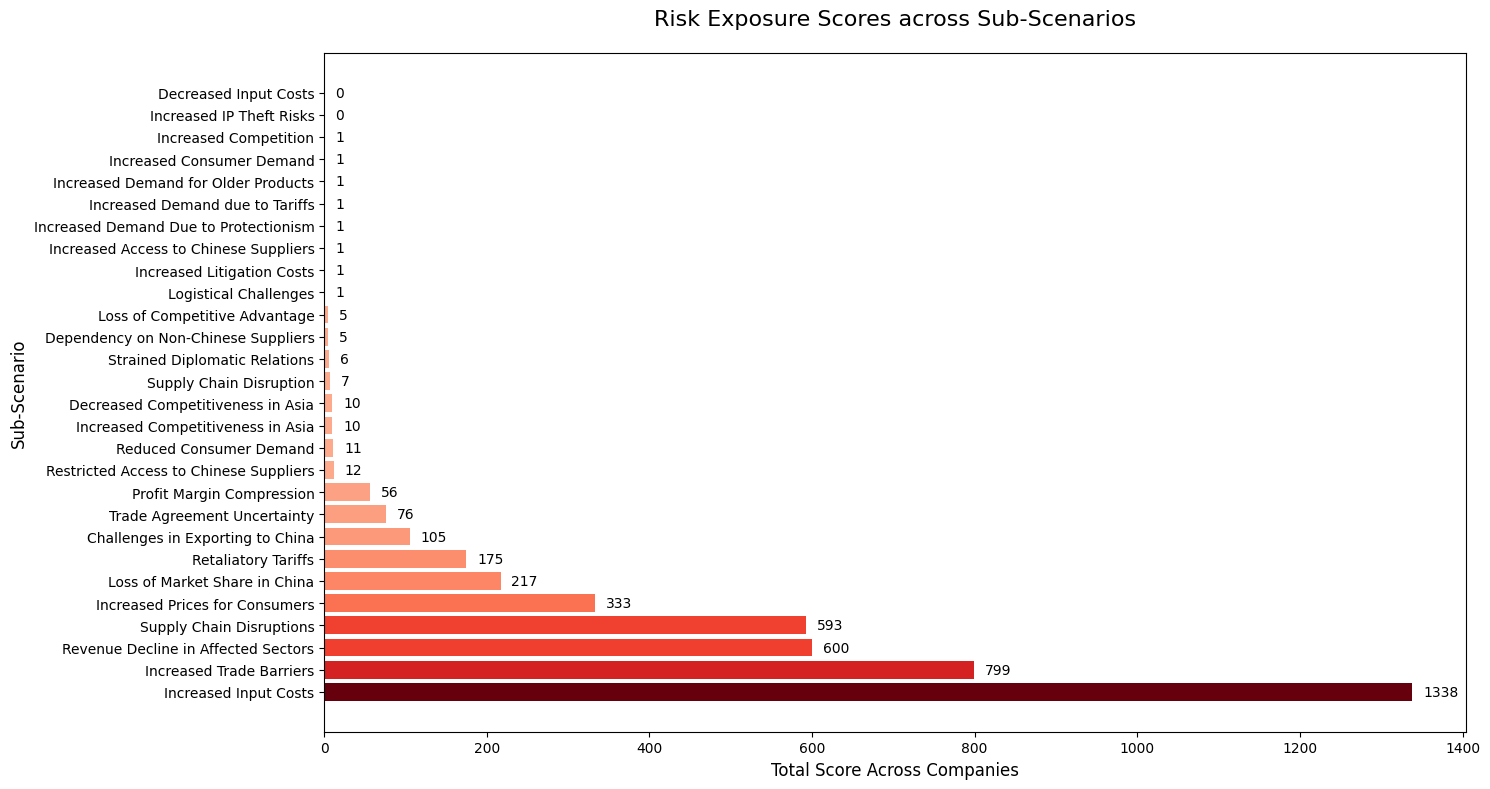

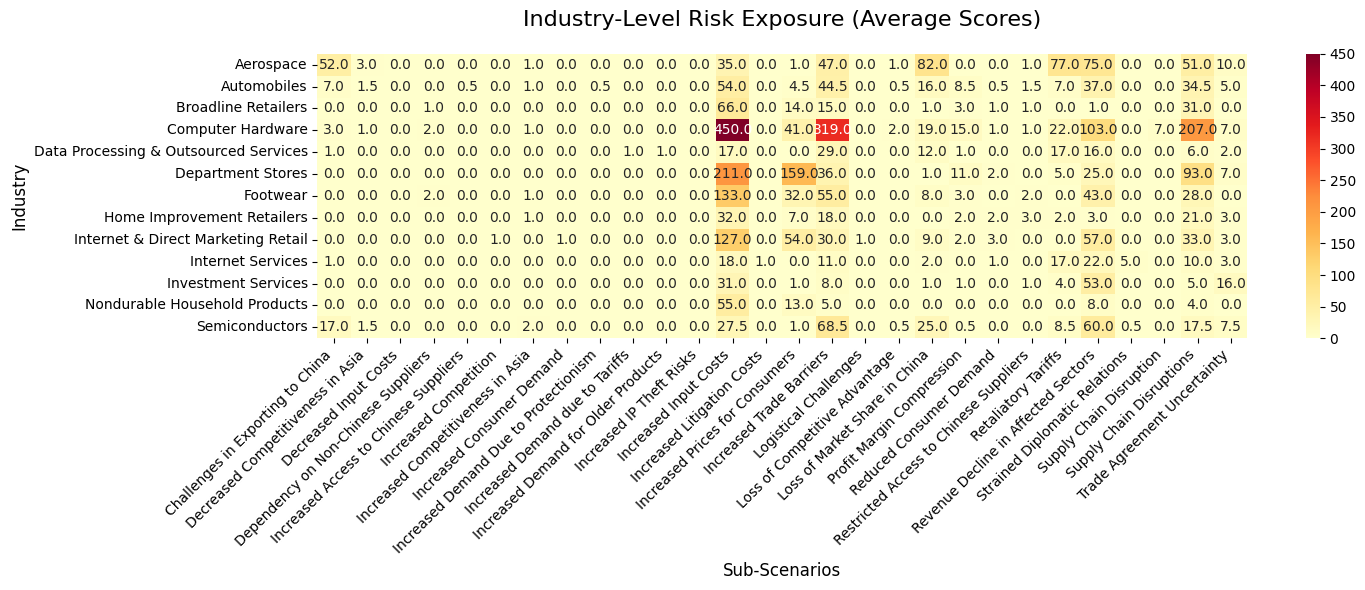

In [55]:
display_figures(df_company, interactive=False, n_companies=15)  # set interactive=True (or False) to enable (or disable) the interactive plot

## Export the Results

Export the data as Excel files for further analysis or to share with the team.

In [ ]:
analyzer.save_results(df_labeled, df_company, df_industry, df_motivation, risk_tree, export_path = export_path)

## Conclusion

This analysis provides key insights for investors seeking to hedge their portfolio against the risk of increasing US Import Tariffs:
 1. Risk Exposure: We've identified companies directly exposed to a specific Risk, indicating how they will be affected by the realization of a specific scenario.
 2. Industry Dynamics: The analysis shows which companies, sectors and industries are most exposed, guiding investors toward areas of potential disruption and opportunities for diversification.
 3. Sub-Scenario Impacts: Companies exposed to specific risks reveal their operational weaknesses and potential for strategic decisions.

Investment Strategy Implications:
- Consider underweighting identified companies exposed to risk
- Sector-Level Diversification: By highlighting concentrated risk exposure across industries, the analysis supports sector-level positioning and hedging strategies, beyond single-name selection.

This analysis equips investors with insights into the increasing risk of US Import Tariffs, highlighting potential losers and their weaknesses for informed investment strategies.